In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import scipy.sparse.linalg 
import scipy
from scipy import sparse
from ECI2 import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 4 digit sitc trade data

/Users/datalab/anaconda3/lib/python3.7/site-packages/ecomplexity/ComplexityData.py:54: UserWarning: Duplicate values exist, keeping the first occurrence
  'Duplicate values exist, keeping the first occurrence')


2017


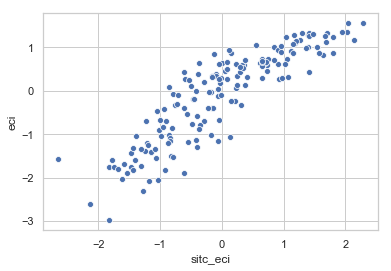

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
from ecomplexity import ecomplexity

# Import trade data from CID Atlas
data = pd.read_csv('../data/country_partner_sitcproduct4digit_year_2017.zip', compression="zip", low_memory=False)
data.head()

# Calculate eci's
data = data[['year','location_code','sitc_product_code','export_value','sitc_eci']]
data = data[data.year==data.year.max()]
trade_cols = {'time':'year', 'loc':'location_code', 'prod':'sitc_product_code', 'val':'export_value'}
cdata = ecomplexity(data, trade_cols)
cdata = cdata[['location_code','eci','sitc_eci']].drop_duplicates(['location_code'])

# Compare against Atlas
sns.scatterplot('sitc_eci','eci', data=cdata)

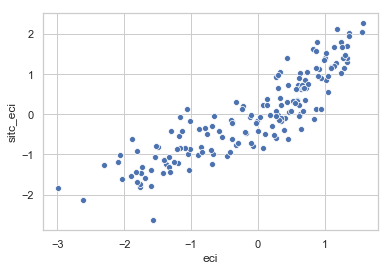

In [143]:
# Compare against Atlas
sns.scatterplot('eci','sitc_eci', data=cdata)

In [121]:
cdata[:10]

,location_code,eci,sitc_eci
0,ABW,0.835738,NaN
4631,AFG,-1.378222,-1.237445
9680,AGO,-1.764049,-1.822037
18791,AIA,1.165619,NaN
19869,ALB,-0.688075,-0.288839
25952,AND,0.328331,1.066444
28707,ANS,0.606416,0.734075
30727,ARE,0.460639,0.057493
38576,ARG,-0.386276,-0.156561
44106,ARM,0.000319,-0.416436


In [124]:
# To download gdp data from wordbank 
# https://data.worldbank.org/indicator/ny.gdp.pcap.cd?most_recent_year_desc=true
df_gdp = pd.read_csv('./GDP/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv', sep = '\t')
year =2017
df_g = df_gdp[['Country Code', str(year)]]
gdp_dict =dict(zip(df_g['Country Code'],df_g[str(year)]))
cdata['gdp'] = [gdp_dict[name] if name in gdp_dict else 0.0 for name in cdata['location_code']]

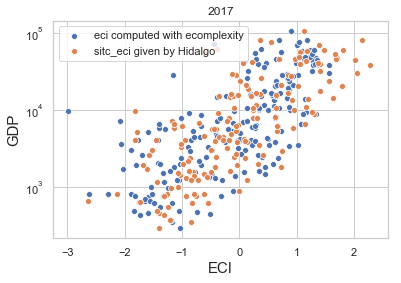

In [142]:
# Compare against Atlas
df = cdata[cdata['gdp'] >0]
sns.scatterplot('eci','gdp', data=df, label = 'eci computed with ecomplexity')
sns.scatterplot('sitc_eci','gdp', data=df, label = 'sitc_eci given by Hidalgo')
plt.yscale('log')
plt.legend()
plt.xlabel('ECI', fontsize = 15)
plt.ylabel('GDP', fontsize = 15)
plt.title('2017');

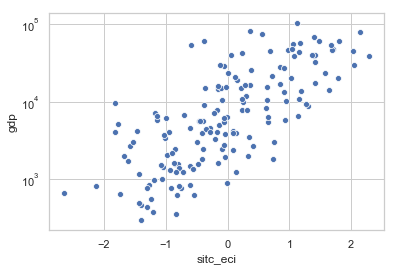

In [128]:
# Compare against Atlas
df = cdata[cdata['gdp'] >0]
sns.scatterplot('sitc_eci','gdp', data=df)
plt.yscale('log');

In [88]:
df = pd.read_csv('../data/country_partner_sitcproduct4digit_year_2017.zip',compression="zip", low_memory=False)

In [89]:
len(df)

4672972

In [90]:
df[:3]

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,location_name_short_en,partner_code,partner_name_short_en,sitc_product_code,sitc_product_name_short_en
0,0,7,696,2017,0,11321,0.633293,-0.044210,ABW,Aruba,ARE,United Arab Emirates,0484,Bakery products
1,1,7,696,2017,0,9772031,-1.237445,-0.921007,AFG,Afghanistan,ARE,United Arab Emirates,0484,Bakery products
2,2,7,696,2017,0,1013881,-1.822037,-1.232933,AGO,Angola,ARE,United Arab Emirates,0484,Bakery products


In [91]:
df = df.drop_duplicates()
len(df)
df_year = df.fillna(0)

In [112]:
len(df_year)

4672972

In [93]:
df_gdp = pd.read_csv('./GDP/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv', sep = '\t')
year =2017
df_g = df_gdp[['Country Code', str(year)]]
gdp_dict =dict(zip(df_g['Country Code'],df_g[str(year)]))

In [94]:
eci_hidago = df_year[['sitc_eci','location_code']].drop_duplicates()

In [95]:
eci_hidago_dict =dict(zip(eci_hidago['location_code'],eci_hidago['sitc_eci']))

In [96]:
x = list(df_year["location_code"])
y = list(df_year["sitc_product_code"])
data = np.array(list(df_year["export_value"]))
sx = list(set(x))
sy =list(set(y))
dx = dict(zip(sx,range(len(sx))))
dy = dict(zip(sy,range(len(sy))))
x1 = [dx[xi] for xi in x]
y1 = [dy[yi] for yi in y]

In [117]:
len(y1), len(x), len(data)

(470, 4672972, 4672972)

In [97]:
# 构建出口矩阵
M = sparse.csc_matrix((data,(x1,y1)),(len(dx),len(dy)))

In [118]:
M

<235x769 sparse matrix of type '<class 'numpy.int64'>'
	with 154175 stored elements in Compressed Sparse Column format>

In [98]:
#计算RCA
R = RCA_sparse(M)

==Time 0.21==


/Users/datalab/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:282: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


In [99]:
R=R.toarray()
R[np.isnan(R)]=0.0

In [100]:
Mat_Dict = Get_eci_pci(np.matrix(R))
eci,pci = Mat_Dict['eci'],Mat_Dict['pci']

==Time 0.51==


In [101]:
#利用稀疏矩阵计算：
Dict = Get_eci_pci_sparse(sparse.csc_matrix(R))
eci_sparse,pci_sparse = Dict['eci'],Dict['pci']

==Time 0.09==


In [102]:
# 利用ecomplexity计算出来的结果
from ecomplexity import ecomplexity
from ecomplexity import proximity
time = [2017]*len(x)
trade_cols = {'time':'year', 'loc':'name', 'prod':'skill', 'val':'value'}
SData=pd.DataFrame({"year":time,'name':x,"skill":y,"value":data})
cdata = ecomplexity(SData, trade_cols)#使用过滤函数
res=pd.DataFrame({'name':list(cdata.name),"eci":list(cdata.eci)})
res = res.drop_duplicates()

/Users/datalab/anaconda3/lib/python3.7/site-packages/ecomplexity/ComplexityData.py:54: UserWarning: Duplicate values exist, keeping the first occurrence
  'Duplicate values exist, keeping the first occurrence')


2017


In [103]:
trade_cols = {'time':'year', 'loc':'location_code', 'prod':'sitc_product_code', 'val':'export_value'}
cdata2 = ecomplexity(df_year, trade_cols)

/Users/datalab/anaconda3/lib/python3.7/site-packages/ecomplexity/ComplexityData.py:54: UserWarning: Duplicate values exist, keeping the first occurrence
  'Duplicate values exist, keeping the first occurrence')


2017


In [104]:
res2=pd.DataFrame({'name':list(cdata2.location_code),"eci":list(cdata2.eci)})
res2 = res2.drop_duplicates()

In [105]:
y =[eci[dx[name]] for name in res.name]
y1 = [eci_sparse[dx[name]] for name in res.name]
y2 = [eci_hidago_dict[name] for name in res.name]
gdp = [gdp_dict[name] if name in gdp_dict else 0.0 for name in res.name]

In [106]:
total=pd.DataFrame({'name':list(res.name),
                    'gdp':gdp,
                    'eci_hidalgo_rep':y2,
                    "eci_ecomplexity_cal":list(res.eci),
                    'eci_mat':y,
                    'eci_sparse':y1})

In [107]:
total.head()

,name,gdp,eci_hidalgo_rep,eci_ecomplexity_cal,eci_mat,eci_sparse
0,ABW,25630.266490,0.633293,0.835738,0.012386,0.012386
1,AFG,556.302138,-1.237445,-1.378222,-1.617771,-1.617771
2,AGO,4095.812942,-1.822037,-1.764049,-0.796055,-0.796055
3,AIA,0.000000,0.940984,1.165619,0.277133,0.277133
4,ALB,4532.889198,-0.288839,-0.688075,0.153267,0.153267


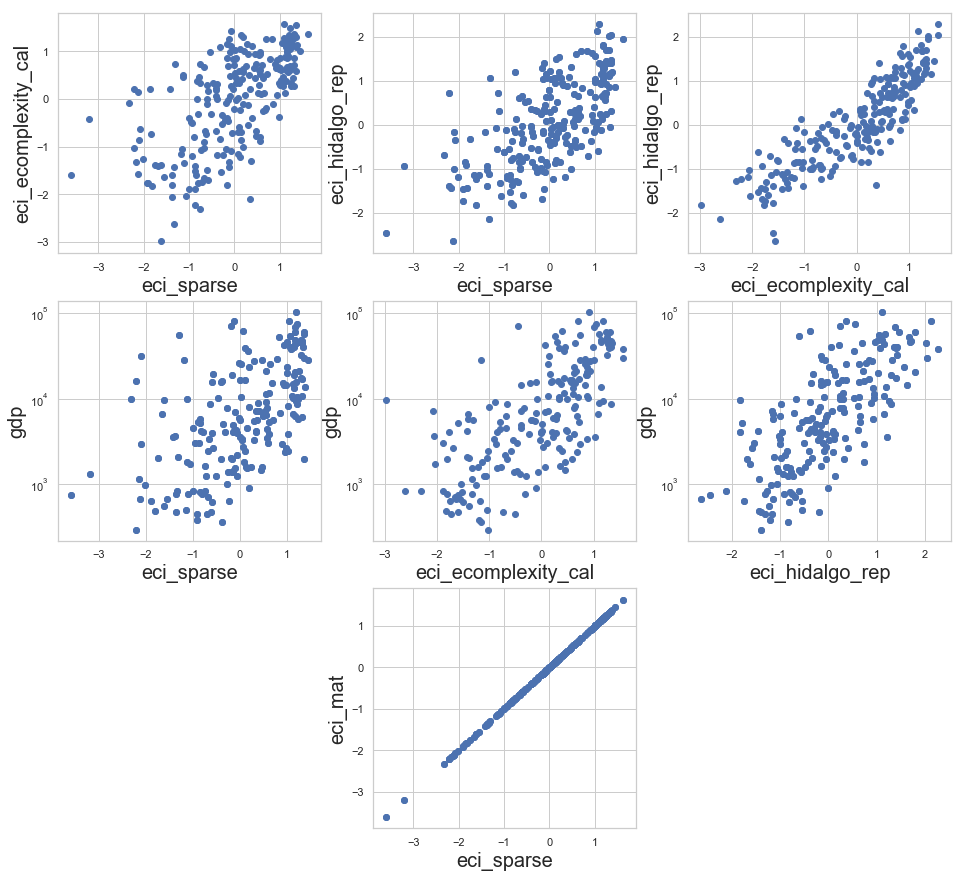

In [141]:
plt.figure(figsize=(16,15))

plt.subplot(338)
plot('eci_sparse', 'eci_mat')
plt.subplot(331)
plot('eci_sparse', 'eci_ecomplexity_cal')
plt.subplot(332)
plot('eci_sparse', 'eci_hidalgo_rep')
plt.subplot(333)
plot('eci_ecomplexity_cal', 'eci_hidalgo_rep')
plt.subplot(334)
plotGDP('eci_sparse', 'gdp')
plt.subplot(335)
plotGDP('eci_ecomplexity_cal', 'gdp')
plt.subplot(336)
plotGDP('eci_hidalgo_rep', 'gdp')


# sitc digit-2 data

In [ ]:
df = pd.read_csv('country_sitcproduct2digit_year.csv',low_memory=False)

In [4]:
year =2017
df_year = df[df['year']==year]
df_year = df_year.drop_duplicates()
df_year = df_year.fillna(0)

In [64]:
df_gdp = pd.read_csv('./GDP/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv', sep = '\t')
df_g = df_gdp[['Country Code', str(year)]]
gdp_dict =dict(zip(df_g['Country Code'],df_g[str(year)]))

In [6]:
eci_hidago = df_year[['sitc_eci','location_code']].drop_duplicates()

In [7]:
eci_hidago_dict =dict(zip(eci_hidago['location_code'],eci_hidago['sitc_eci']))

In [8]:
x = list(df_year["location_code"])
y = list(df_year["sitc_product_code"])
data = np.array(list(df_year["export_value"]))
sx = list(set(x))
sy =list(set(y))
dx = dict(zip(sx,range(len(sx))))
dy = dict(zip(sy,range(len(sy))))
x1 = [dx[xi] for xi in x]
y1 = [dy[yi] for yi in y]

In [9]:
# 构建出口矩阵
M = sparse.csc_matrix((data,(x1,y1)),(len(dx),len(dy)))

In [10]:
#计算RCA
R = RCA_sparse(M)

==Time 0.03==


/Users/datalab/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:597: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(self.todense(), other)
/Users/datalab/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:597: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/Users/datalab/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:208: RuntimeWarning: invalid value encountered in greater_equal
  res = self._with_data(op(self.data, other), copy=True)
/Users/datalab/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:282: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


In [11]:
R=R.toarray()
R[np.isnan(R)]=0.0

In [12]:
Mat_Dict = Get_eci_pci(np.matrix(R))
eci,pci = Mat_Dict['eci'],Mat_Dict['pci']

==Time 0.01==


In [13]:
#利用稀疏矩阵计算：
Dict = Get_eci_pci_sparse(sparse.csc_matrix(R))
eci_sparse,pci_sparse = Dict['eci'],Dict['pci']

==Time 0.01==


In [14]:
# 利用ecomplexity计算出来的结果
from ecomplexity import ecomplexity
from ecomplexity import proximity
time = [2017]*len(x)
trade_cols = {'time':'year', 'loc':'name', 'prod':'skill', 'val':'value'}
SData=pd.DataFrame({"year":time,'name':x,"skill":y,"value":data})
cdata = ecomplexity(SData, trade_cols)#使用过滤函数
res=pd.DataFrame({'name':list(cdata.name),"eci":list(cdata.eci)})
res = res.drop_duplicates()

2017


In [15]:
df_year = df[df['year']==year]
trade_cols = {'time':'year', 'loc':'location_code', 'prod':'sitc_product_code', 'val':'export_value'}
cdata2 = ecomplexity(df_year, trade_cols)

2017


In [16]:
res2=pd.DataFrame({'name':list(cdata2.location_code),"eci":list(cdata2.eci)})
res2 = res2.drop_duplicates()

In [65]:
y =[eci[dx[name]] for name in res.name]
y1 = [eci_sparse[dx[name]] for name in res.name]
y2 = [eci_hidago_dict[name] for name in res.name]
gdp = [gdp_dict[name] if name in gdp_dict else 0.0 for name in res.name]

In [66]:
total=pd.DataFrame({'name':list(res.name),
                    'gdp':gdp,
                    'eci_hidalgo_rep':y2,
                    "eci_ecomplexity_cal":list(res.eci),
                    'eci_mat':y,
                    'eci_sparse':y1})

In [67]:
total.head()

,name,gdp,eci_hidalgo_rep,eci_ecomplexity_cal,eci_mat,eci_sparse
0,ABW,25630.266490,0.633293,-0.428741,-0.430580,-0.430580
1,AFG,556.302138,-1.237445,-1.080686,-1.083838,-1.083838
2,AGO,4095.812942,-1.822037,-1.478833,-1.482787,-1.482787
3,AIA,0.000000,0.940984,1.044546,1.045672,1.045672
4,ALB,4532.889198,-0.288839,-0.195837,-0.197208,-0.197208


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
sns.set(style="whitegrid")
#for key in [ "eci_hidalgo_rep","eci_ecomplexity_cal","eci_mat","eci_sparse"]:

<Figure size 360x360 with 0 Axes>

In [80]:
def plot(key1, key2):
    # [ "eci_hidalgo_rep","eci_ecomplexity_cal","eci_mat","eci_sparse"]
    plt.scatter(total[key1], total[key2])
    plt.xlabel(key1,fontsize=20)
    plt.ylabel(key2,fontsize=20)
    #plt.show()
    
def plotGDP(key1, key2):
    df = total[total['gdp'] >0]
    plt.scatter(df[key1], df[key2])
    plt.xlabel(key1,fontsize=20)
    plt.ylabel(key2,fontsize=20)
    plt.yscale('log')

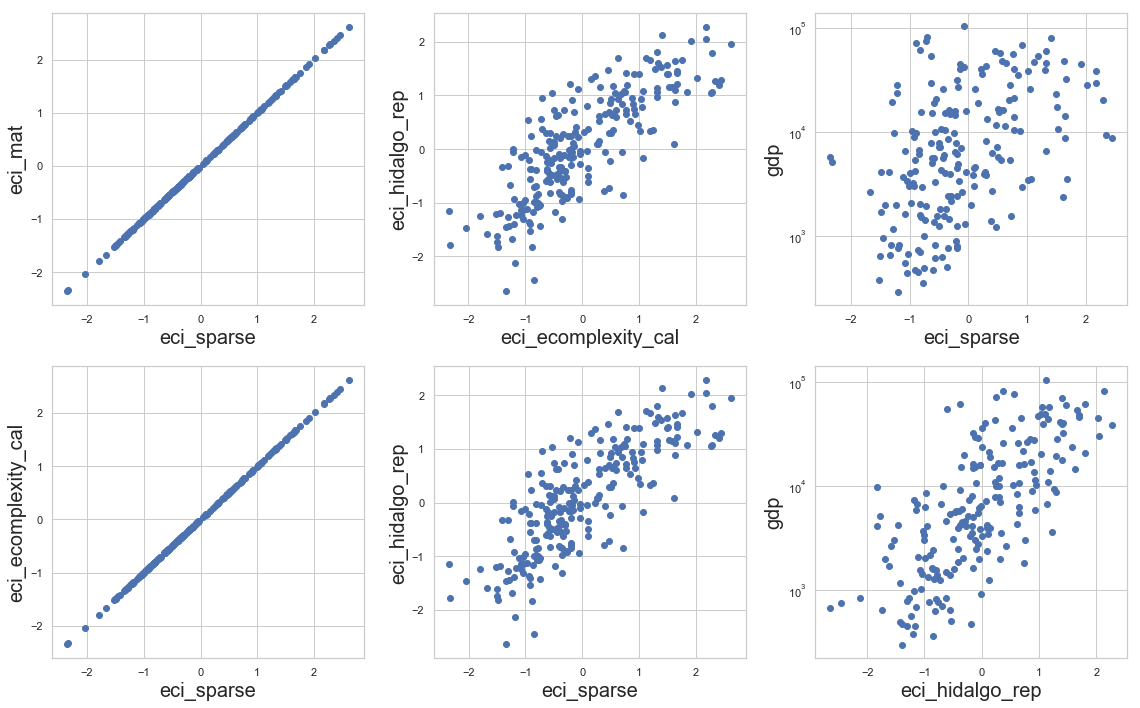

In [85]:
plt.figure(figsize=(16,10))

plt.subplot(231)
plot('eci_sparse', 'eci_mat')
plt.subplot(234)
plot('eci_sparse', 'eci_ecomplexity_cal')
plt.subplot(232)
plot('eci_ecomplexity_cal', 'eci_hidalgo_rep')
plt.subplot(235)
plot('eci_sparse', 'eci_hidalgo_rep')
plt.subplot(233)
plotGDP('eci_sparse', 'gdp')
plt.subplot(236)
plotGDP('eci_hidalgo_rep', 'gdp')
plt.tight_layout()

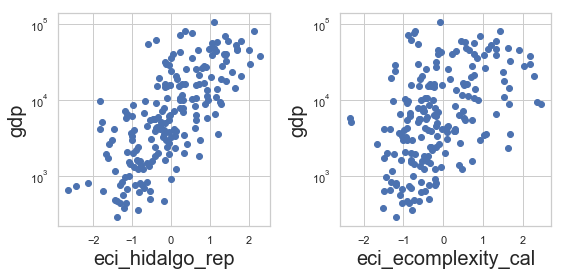

In [87]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plotGDP('eci_hidalgo_rep', 'gdp')
plt.subplot(122)
plotGDP('eci_ecomplexity_cal', 'gdp')
plt.tight_layout()